In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings

np.random.seed = 42

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer, label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

In [3]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Diabetes_012'])

In [4]:
colors = ['#602CA3', '#FE4680', '#FE9B06']

### Feature engineering

In [5]:
def bin_BMI(data):
    bins = [0, 18.5, 24.9, 29.9, float('inf')]
    labels = ['Underweight', 'Healthy weight', 'Overweight', 'Obesity']
    data['binned_BMI'] = pd.cut(data['BMI'], bins=bins, labels=labels)
    data['binned_BMI'] = data['binned_BMI'].cat.codes
    return data

def calculate_OverallHealthStatus(data):
    weights = {'GenHlth': 0.7, 'MentHlth': 0.01, 'PhysHlth': 0.01}
    weighted_scores = data[['GenHlth', 'MentHlth', 'PhysHlth']] * pd.Series(weights)
    data['OverallHealthStatus'] = weighted_scores.sum(axis=1)
    return data

def calculate_OverallHealthRisk(data):
    weights = {'HighBP': 1.3, 'HighChol': 1, 'Stroke': 0.8, 'HeartDiseaseorAttack': 1.3}
    weighted_scores = data[['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack']] * pd.Series(weights)
    data['OverallHealthRisk'] = weighted_scores.sum(axis=1)
    return data

def calculate_OverallHealthRisk_CDC(data):
    data['OverallHealthRisk_CDC'] = data[['BMI', 'Age', 'PhysActivity']].mean(axis=1)
    return data

def identify_NutritiousFood(data):
    data['NutritiousFood'] = (data['Fruits'].astype(bool) & data['Veggies'].astype(bool)).astype(int)
    return data

def identify_BadHabits(data):
    data['BadHabits'] = (data['Smoker'].astype(bool) & data['HvyAlcoholConsump'].astype(bool)).astype(int)
    return data

def deleteRepeated(data):
    data.drop(['GenHlth', 'MentHlth', 'PhysHlth', 'HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'BMI', 'Age', 'PhysActivity', "Fruits", 
               "Veggies", "Smoker", 'HvyAlcoholConsump'], axis=1, inplace=True)
    return data

feature_engineering_pipeline = Pipeline([
    ('bin_BMI', FunctionTransformer(bin_BMI)),
    ('calculate_OverallHealthStatus', FunctionTransformer(calculate_OverallHealthStatus)),
    ('calculate_OverallHealthRisk', FunctionTransformer(calculate_OverallHealthRisk)),
    ('calculate_OverallHealthRisk_CDC', FunctionTransformer(calculate_OverallHealthRisk_CDC)),
    ('identify_NutritiousFood', FunctionTransformer(identify_NutritiousFood)),
    ('identify_BadHabits', FunctionTransformer(identify_BadHabits)),
    ('deleteRepeated', FunctionTransformer(deleteRepeated))
])

In [6]:
X_dev = feature_engineering_pipeline.transform(X_dev)

In [7]:
y = np.array(X_dev['Diabetes_012'])
X = X_dev.drop(['Diabetes_012'],axis=1)

y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = 3

X_train, X_val, y_train, y_val = train_test_split(X, y_bin, test_size=0.33, random_state=0)

In this section, we will conduct hyperparameter tuning for selected models. The code includes the ROC_AUC score for each model before and after tuning.

## Models

In [8]:
def draw_ROC_curve(y_val, y_score, typ_modelu):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curve for each class - ' + typ_modelu)
    plt.legend(loc='lower right')
    plt.show()
    
def AUC_GINI_plot(y_val, y_score, typ_modelu):
    bl = pd.DataFrame(0, index=range(0), columns=range(3))
    bl.columns = ["class", "error", "error_value"]
    j = 0
    
    for i in range(n_classes):
        AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
        gini = 2*AUC - 1
        
        bl.loc[j] = [i, "AUC", AUC]
        j+=1
        bl.loc[j] = [i, "GINI", gini]
        j+=1
    ax = sns.barplot(x= bl["error"], y=bl["error_value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.bar_label(ax.containers[2])
    plt.ylim(0, 1)
    plt.xlabel(None)
    plt.title("Comparison of AUC and GINI for each class - " + typ_modelu)
    plt.show()

### Linear Discriminant Analysis (LDA)

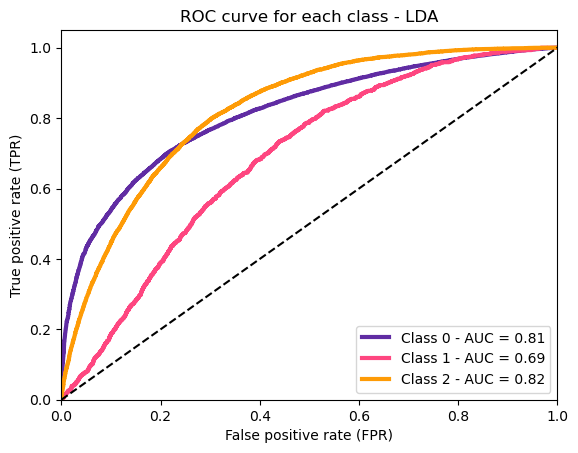

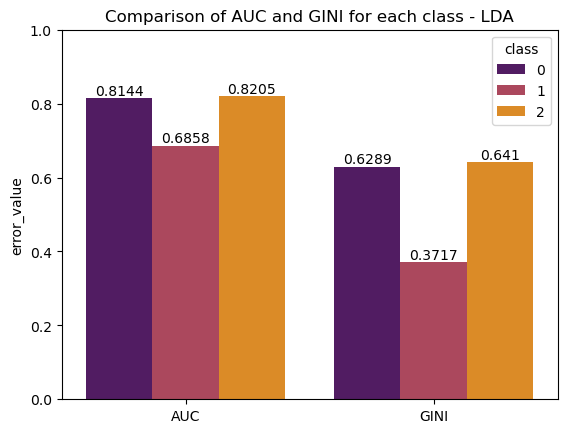

roc_auc_ovr: 0.7736


In [16]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train.argmax(axis=1))

y_score = lda.decision_function(X_val)

draw_ROC_curve(y_val, y_score, 'LDA')

AUC_GINI_plot(y_val, y_score, 'LDA')

roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

### Multinomial Logistic Regression

#### without tuning

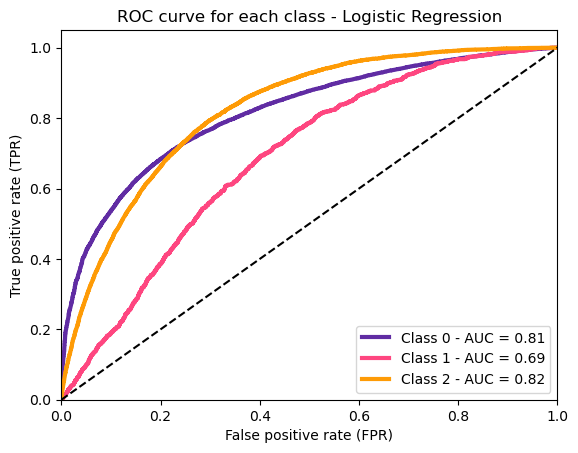

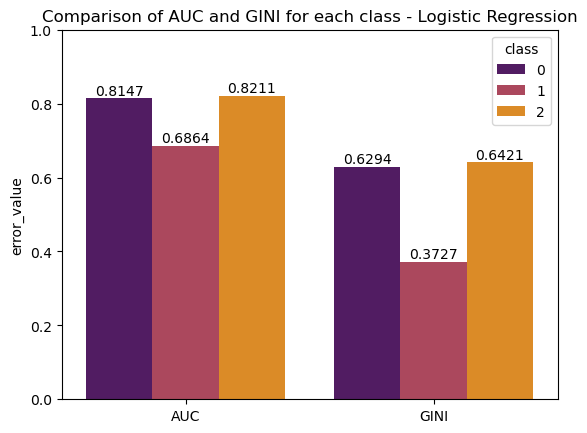

roc_auc_ovr: 0.7740


In [9]:
clf = LogisticRegression(multi_class='multinomial',max_iter=2000)
clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Logistic Regression')

AUC_GINI_plot(y_val, y_score, 'Logistic Regression')

roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

#### tuning

In [10]:
clf = LogisticRegression(multi_class='multinomial', max_iter=2000)

param_grid = {
    'C': [0.001,0.01, 0.1,1],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc_ovr')
grid_search.fit(X_train, y_train.argmax(axis=1))

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


#Best parameters: {'C': 0.01, 'solver': 'sag'}
#Best parameters: {'C': 0.01, 'solver': 'newton-cg'}

Best parameters: {'C': 0.01, 'solver': 'newton-cg'}


#### after tuning

roc_auc_ovr: 0.7740


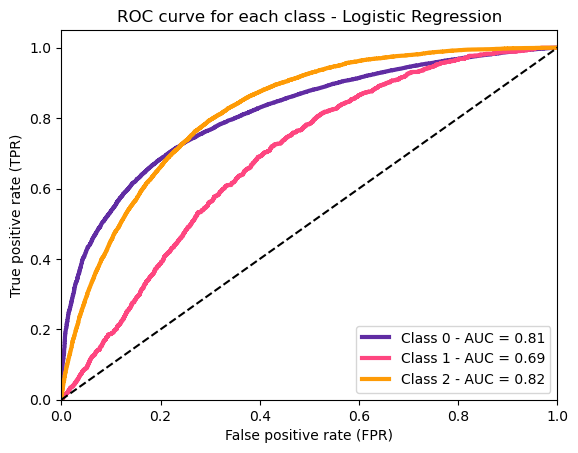

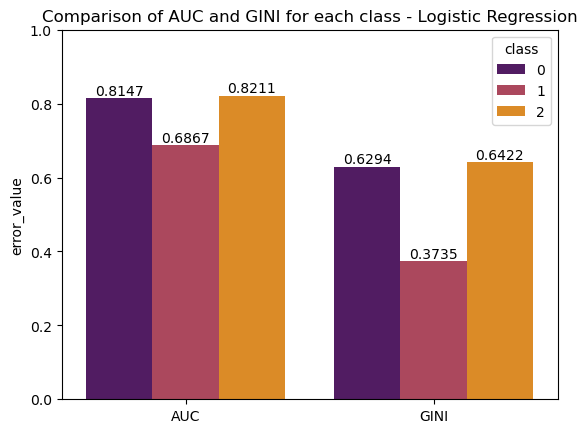

In [11]:
clf_best = LogisticRegression(multi_class='multinomial', max_iter=2000, **best_params)
clf_best.fit(X_train, y_train.argmax(axis=1))

y_pred = clf_best.predict_proba(X_val)

roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

draw_ROC_curve(y_val, y_pred, 'Logistic Regression')

AUC_GINI_plot(y_val, y_pred, 'Logistic Regression')

### Gaussian Naive Bayes

#### without tuning

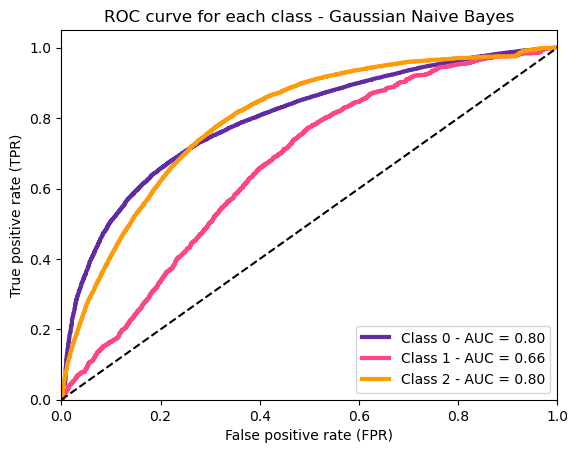

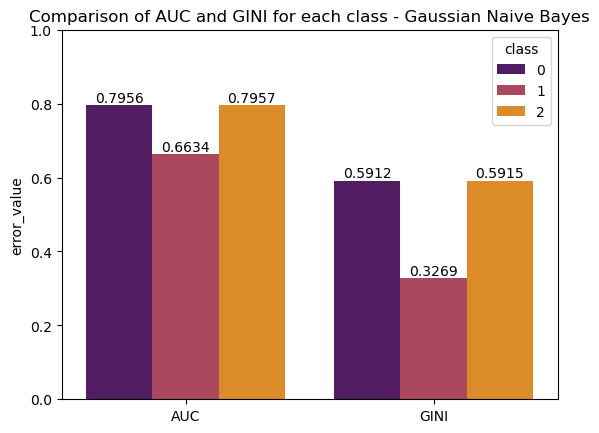

roc_auc_ovr: 0.7516


In [17]:
clf = GaussianNB()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Gaussian Naive Bayes')

AUC_GINI_plot(y_val, y_score, 'Gaussian Naive Bayes')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")


#### tuning

In [18]:
clf = GaussianNB()

param_grid = {
    'var_smoothing': [1e-13, 1e-10, 1e-7, 1e-5,1e-3, 1e-2, 1e-1,1,3,5]
}

grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc_ovr')
grid_search.fit(X_train, y_train.argmax(axis=1))

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


#Best parameters: {'var_smoothing': 0.001}
#Best parameters: {'var_smoothing': 0.1}

Best parameters: {'var_smoothing': 0.1}


#### after tuning

roc_auc_ovr: 0.7662


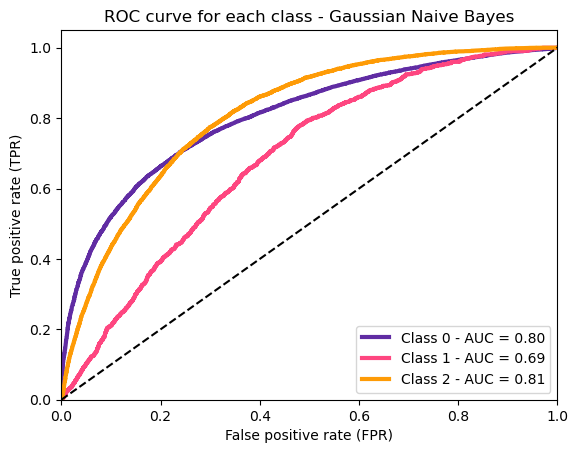

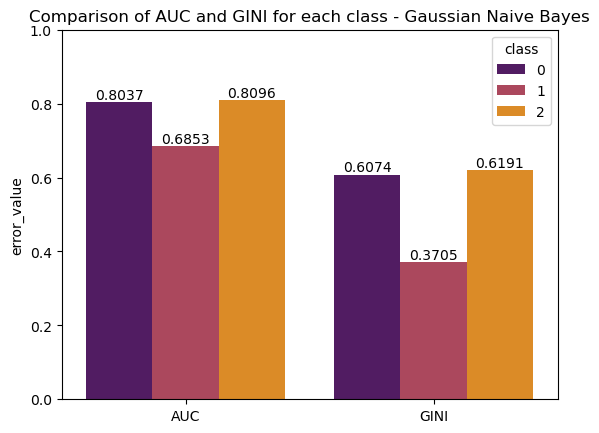

roc_auc_ovr: 0.7516


In [20]:
clf_best = GaussianNB(**best_params)
clf_best.fit(X_train, y_train.argmax(axis=1))

y_pred = clf_best.predict_proba(X_val)

roc_auc_ovr = roc_auc_score(y_val, y_pred, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")


draw_ROC_curve(y_val, y_pred, 'Gaussian Naive Bayes')

AUC_GINI_plot(y_val, y_pred, 'Gaussian Naive Bayes')

roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")


### Gradient Boosting for classification

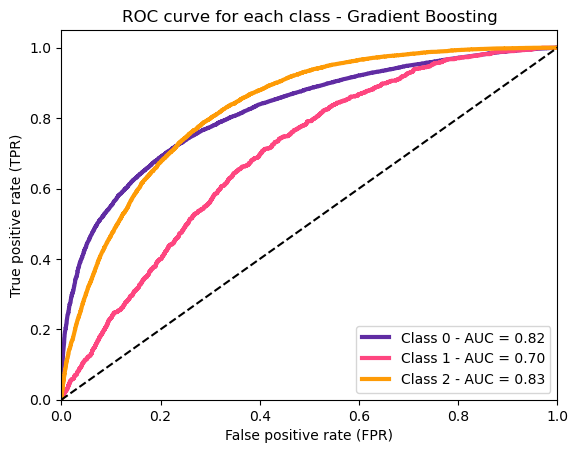

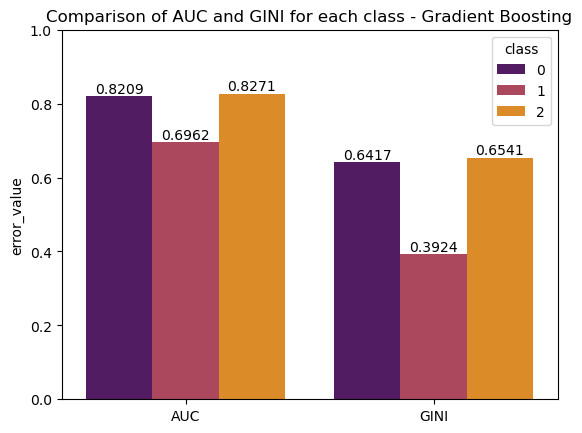

roc_auc_ovr: 0.7814


In [21]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Gradient Boosting')

AUC_GINI_plot(y_val, y_score, 'Gradient Boosting')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

#### tuning

In [ ]:
clf = GradientBoostingClassifier()

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 4, 5],
#     'min_samples_leaf': [1, 2, 3]
# }

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc_ovr', cv=3)
grid_search.fit(X_train, y_train.argmax(axis=1))

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# After runing GridSearchCV for each parameter separately:
#Best parameters: {'min_samples_leaf': 3} # default = 1
#Best parameters: {'max_depth': 3} # default = 3
#Best parameters: {'n_estimators': 100} # default = 100
#Best parameters: {'learning_rate': 0.1} # default = 0.1

In [10]:
clf = GradientBoostingClassifier()

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

random_search = RandomizedSearchCV(clf, param_distributions, n_iter=20, cv=3, scoring="roc_auc_ovr", n_jobs=-1)

random_search.fit(X_train, y_train.argmax(axis=1))

best_params = random_search.best_params_

print(f"Best parameters: {best_params}")

#Best parameters: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}
#Best parameters: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}

Best parameters: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}


#### after tuning

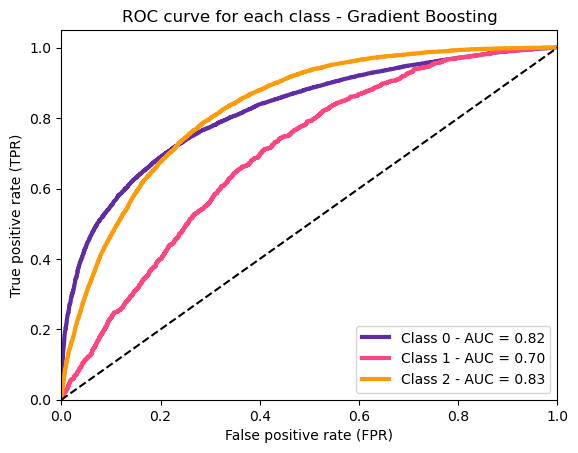

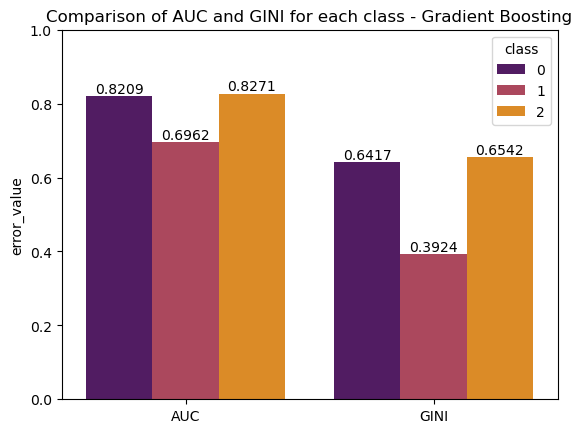

roc_auc_ovr: 0.7814


In [11]:
# with best parameters from random search
clf = GradientBoostingClassifier(**best_params)

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Gradient Boosting')

AUC_GINI_plot(y_val, y_score, 'Gradient Boosting')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

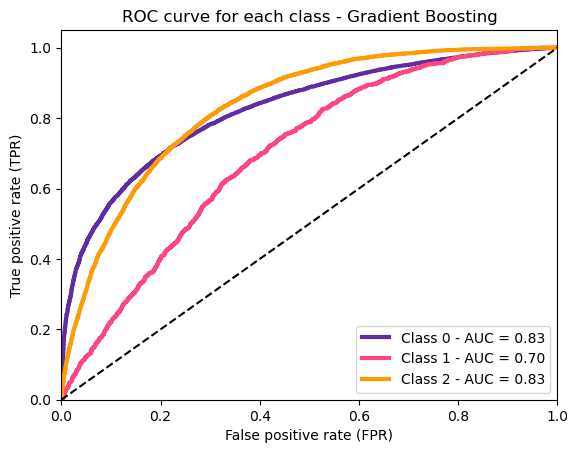

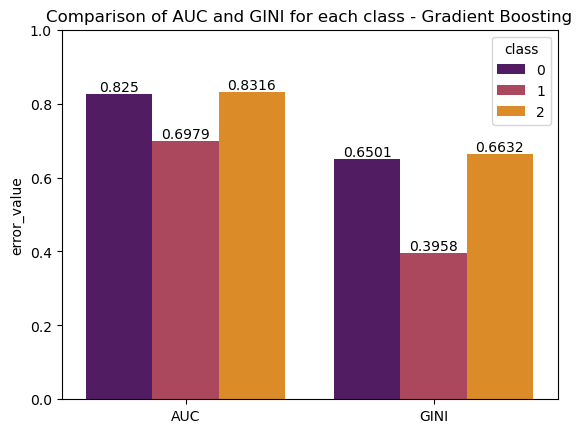

roc_auc_ovr: 0.7848


In [26]:
# with parameters After runing GridSearchCV for each parameter separately
clf = GradientBoostingClassifier(min_samples_leaf = 3)

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Gradient Boosting')

AUC_GINI_plot(y_val, y_score, 'Gradient Boosting')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

### AdaBoost classifier

#### before  tuning

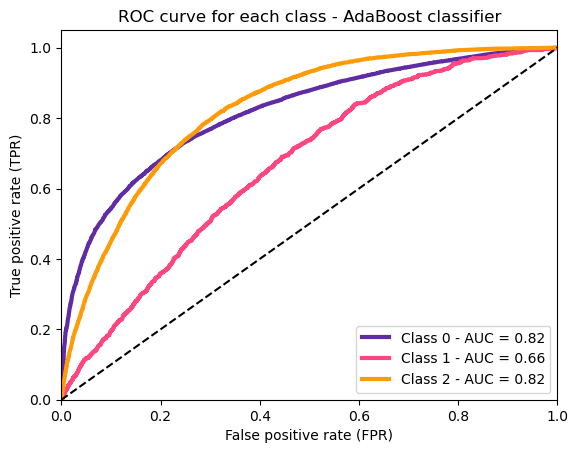

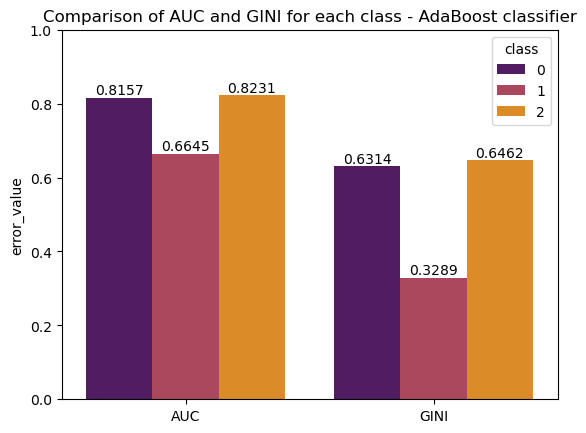

roc_auc_ovr: 0.7678


In [22]:
clf = AdaBoostClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.decision_function(X_val)

draw_ROC_curve(y_val, y_score, 'AdaBoost classifier')

AUC_GINI_plot(y_val, y_score, 'AdaBoost classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

#### tuning

In [23]:
clf = AdaBoostClassifier()

param_grid = {
    "n_estimators": [25,50, 100, 200],
    "estimator": [DecisionTreeClassifier(max_depth=1, criterion ='gini'), DecisionTreeClassifier(max_depth=4, criterion = 'gini'), DecisionTreeClassifier(max_depth=7, criterion = 'gini'),
                 DecisionTreeClassifier(max_depth=1, criterion ='entropy'), DecisionTreeClassifier(max_depth=4, criterion = 'entropy'), DecisionTreeClassifier(max_depth=7, criterion = 'entropy')]
}

grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc_ovr', cv=3)
grid_search.fit(X_train, y_train.argmax(axis=1))

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

#Best parameters: {'estimator': DecisionTreeClassifier(max_depth=1), 'n_estimators': 25}
#Best parameters: {'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'n_estimators': 25}

Best parameters: {'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'n_estimators': 25}


#### after tuning

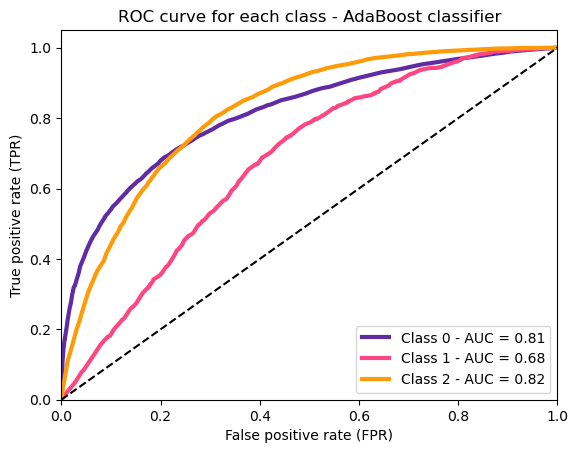

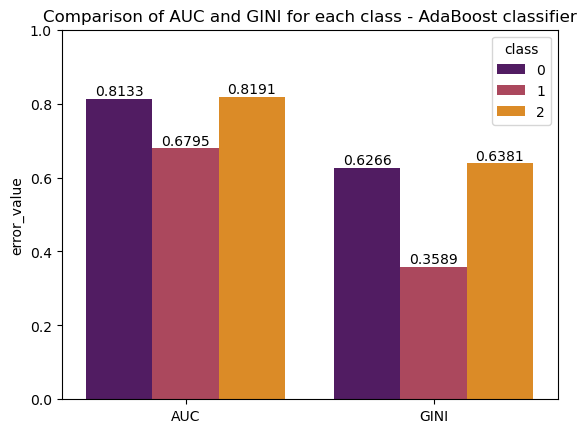

roc_auc_ovr: 0.7706


In [24]:
# clf = AdaBoostClassifier(**best_params)

clf = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1), n_estimators=15)

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'AdaBoost classifier')

AUC_GINI_plot(y_val, y_score, 'AdaBoost classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

### Decision Tree Classifier

#### before tuning

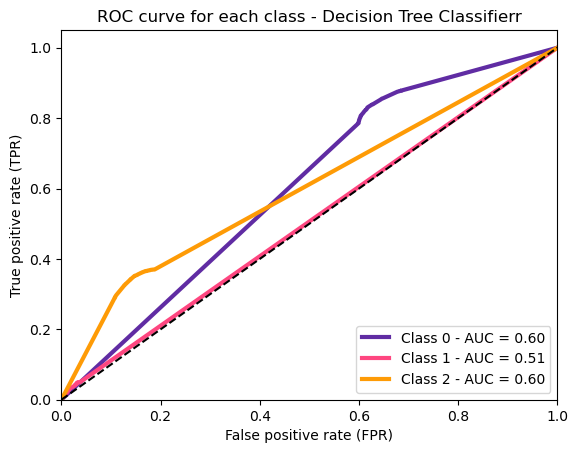

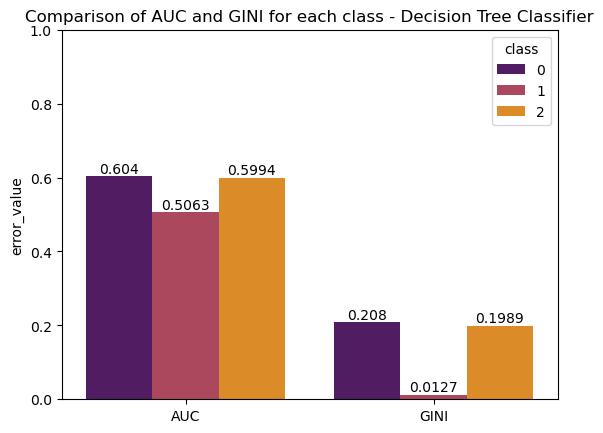

roc_auc_ovr: 0.5699


In [25]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Decision Tree Classifierr')

AUC_GINI_plot(y_val, y_score, 'Decision Tree Classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

#### tuning

In [26]:
clf = DecisionTreeClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(3, 15),
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc_ovr', cv=3)
grid_search.fit(X_train, y_train.argmax(axis=1))

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

#Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1}
#Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1}

Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1}


#### after tuning

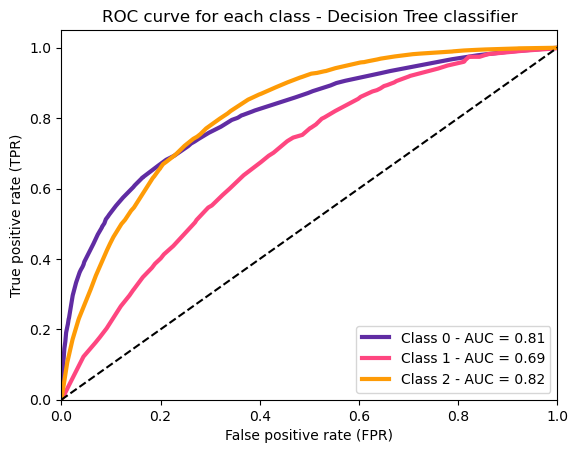

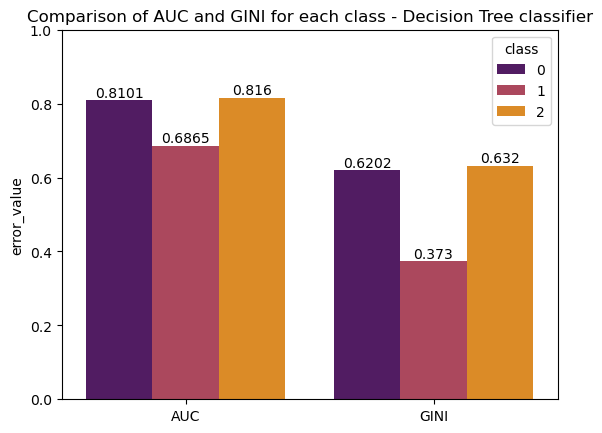

roc_auc_ovr: 0.7709


In [27]:
clf = DecisionTreeClassifier(**best_params)

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'Decision Tree classifier')

AUC_GINI_plot(y_val, y_score, 'Decision Tree classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

### XGBoost

#### before tuning

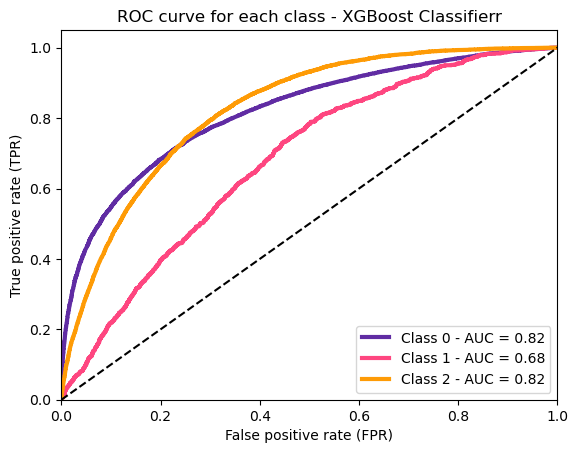

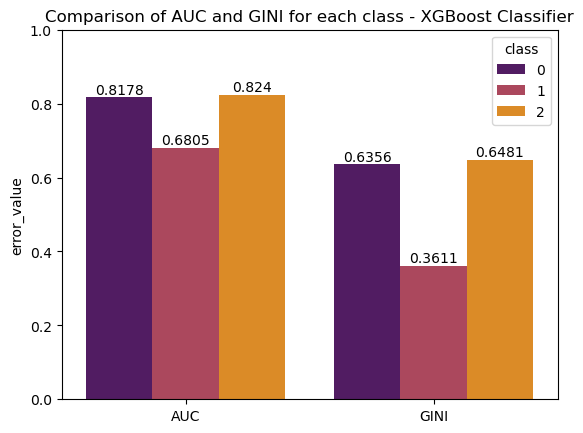

roc_auc_ovr: 0.7741


In [13]:
clf = XGBClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'XGBoost Classifierr')

AUC_GINI_plot(y_val, y_score, 'XGBoost Classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

#### tuning

In [14]:
clf = XGBClassifier()

param_grid = {
    "max_depth": range(2, 10),
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc_ovr', cv=3)
grid_search.fit(X_train, y_train.argmax(axis=1))

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

#Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
#Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}


#### aftertuning

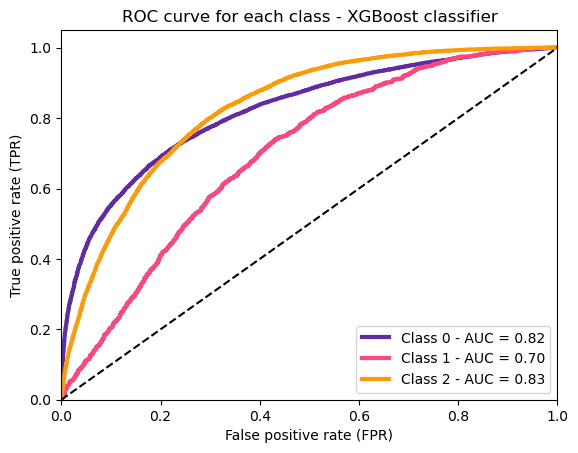

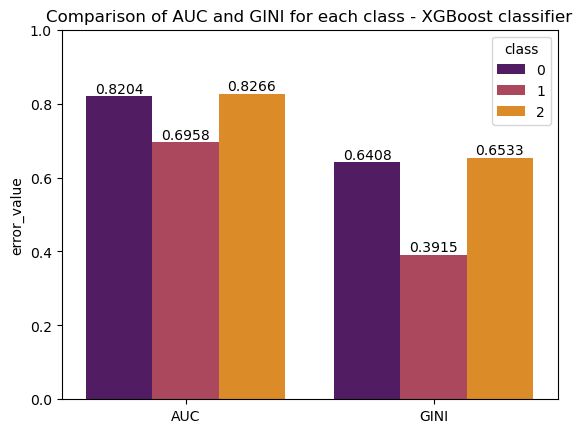

roc_auc_ovr: 0.7809


In [15]:
clf = XGBClassifier(**best_params)

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'XGBoost classifier')

AUC_GINI_plot(y_val, y_score, 'XGBoost classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

### Multi-layer Perceptron classifier

#### before tuning

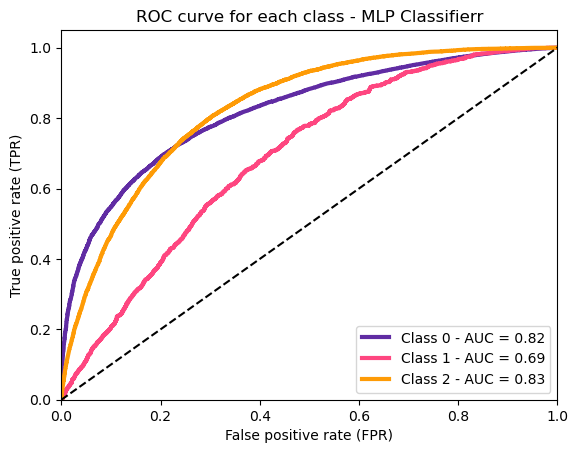

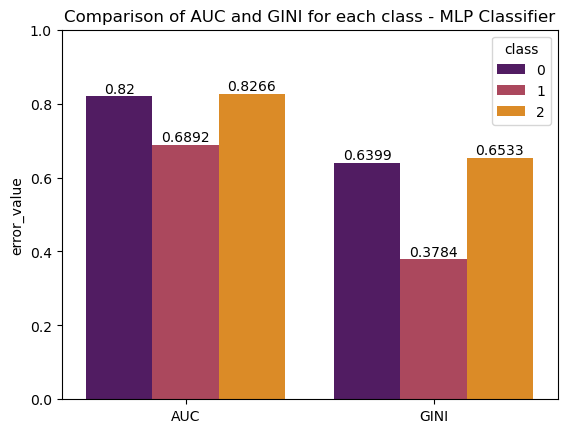

roc_auc_ovr: 0.7786


In [28]:
# clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation='relu', solver='adam', random_state=0)

clf = MLPClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'MLP Classifierr')

AUC_GINI_plot(y_val, y_score, 'MLP Classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")

#### tuning

In [29]:
clf = MLPClassifier(max_iter=1000)

param_distributions = {
    "hidden_layer_sizes": [(100, 2), (100, 3)],
    "activation": ["logistic", "relu", "tanh"],
    "alpha": 10.0 ** -np.arange(1, 3),
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "solver": ["lbfgs", "adam"],
    "early_stopping": [False,True]
}

random_search = RandomizedSearchCV(clf, param_distributions, n_iter=30, cv=3, scoring="roc_auc_ovr", n_jobs=-1)

random_search.fit(X_train, y_train.argmax(axis=1))

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

#Best parameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 3), 'early_stopping': False, 'alpha': 0.01, 'activation': 'logistic'}
#
clf = MLPClassifier(max_iter=1000)

param_distributions = {
    "hidden_layer_sizes": [(100, 2), (100, 3)],
    "activation": ["logistic", "relu", "tanh"],
    "alpha": 10.0 ** -np.arange(1, 3),
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "solver": ["lbfgs", "adam"],
    "early_stopping": [False,True]
}

random_search = RandomizedSearchCV(clf, param_distributions, n_iter=30, cv=3, scoring="roc_auc_ovr", n_jobs=-1)

random_search.fit(X_train, y_train.argmax(axis=1))

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

#Best parameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 3), 'early_stopping': False, 'alpha': 0.01, 'activation': 'logistic'}
#Best parameters: {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 3), 'early_stopping': False, 'alpha': 0.1, 'activation': 'logistic'}

Best parameters: {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 3), 'early_stopping': False, 'alpha': 0.1, 'activation': 'logistic'}


C:\Users\okroj\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### after tuning

C:\Users\okroj\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


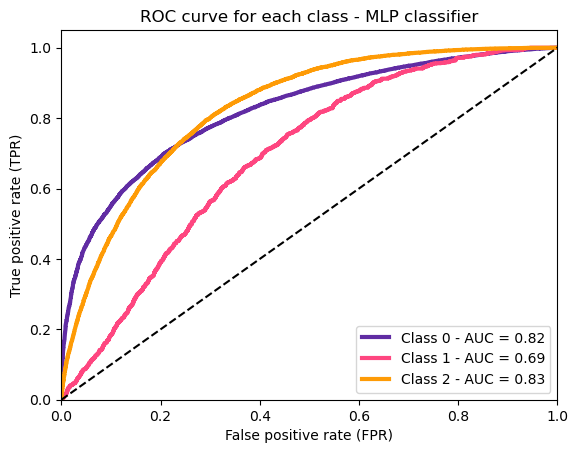

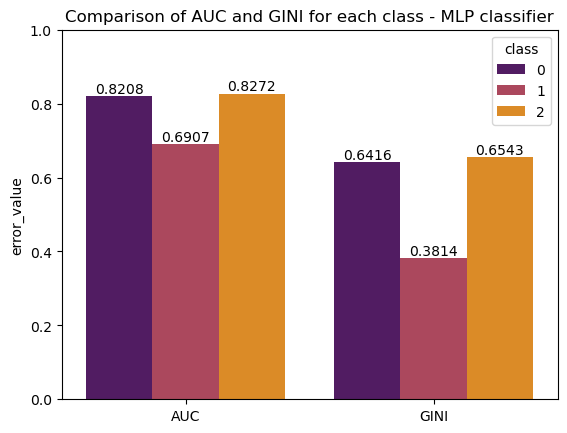

roc_auc_ovr: 0.7796


In [9]:
clf = MLPClassifier(max_iter=1000, solver = 'lbfgs', learning_rate = 'constant', hidden_layer_sizes = (100, 3), early_stopping = False, 
                    alpha = 0.1, activation = 'logistic')

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

draw_ROC_curve(y_val, y_score, 'MLP classifier')

AUC_GINI_plot(y_val, y_score, 'MLP classifier')
roc_auc_ovr = roc_auc_score(y_val, y_score, multi_class='ovr')

print(f"roc_auc_ovr: {roc_auc_ovr:.4f}")